In [1]:
%matplotlib inline

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns

In [3]:
!sbt "run-main ZeroIntelligenceApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Running ZeroIntelligenceApp 
[info] -XX:InitialHeapSize=268435456 -XX:MaxHeapSize=4294967296 -XX:+PrintCommandLineFlags -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseParallelGC 
[success] Total time: 8 s, completed Mar 24, 2016 10:34:00 AM


## Importing the raw data

In [4]:
# this is a bit of a hack as current log files are not valid JSON!
with open('./data/fills.log') as data_file:    
    zi_data = pd.read_json('[%s]' % ','.join(data_file.read().splitlines()))
    zi_data.set_index('timestamp', inplace=True)

In [5]:
zi_data.head()

,askPrice,bidPrice,class,price,quantity,tradable
timestamp,,,,,,
2016-03-24 10:33:53.889,4,149,markets.Fill,4,1,Gpi2
2016-03-24 10:33:53.907,37,62,markets.Fill,37,1,Gpi2
2016-03-24 10:33:53.907,92,145,markets.Fill,92,1,Gpi2
2016-03-24 10:33:53.910,86,145,markets.Fill,145,1,Gpi2
2016-03-24 10:33:53.910,91,131,markets.Fill,131,1,Gpi2


In [6]:
zi_data.tail()

,askPrice,bidPrice,class,price,quantity,tradable
timestamp,,,,,,
2016-03-24 10:33:59.290,31,87,markets.Fill,87,1,Gpi2
2016-03-24 10:33:59.290,109,140,markets.Fill,109,1,Gpi2
2016-03-24 10:33:59.290,76,80,markets.Fill,80,1,Gpi2
2016-03-24 10:33:59.290,92,159,markets.Fill,92,1,Gpi2
2016-03-24 10:33:59.373,25,61,markets.Fill,61,1,Gpi2


In [7]:
zi_data.describe()

,askPrice,bidPrice,price,quantity
count,99745.000000,99745.000000,99745.000000,99745
mean,78.133170,121.968600,99.915585,1
std,45.010058,45.033444,31.054610,0
min,1.000000,30.000000,4.000000,1
25%,39.000000,83.000000,74.000000,1
50%,78.000000,122.000000,100.000000,1
75%,117.000000,161.000000,125.000000,1
max,162.000000,199.000000,162.000000,1


### Compute the bid-ask spread...

    spread = bidPrice - askPice

In [8]:
zi_data['spread'] = zi_data.bidPrice - zi_data.askPrice

In [9]:
zi_data.spread.describe()

count    99745.000000
mean        43.835430
std         29.916339
min          1.000000
25%         20.000000
50%         39.000000
75%         62.000000
max        154.000000
Name: spread, dtype: float64

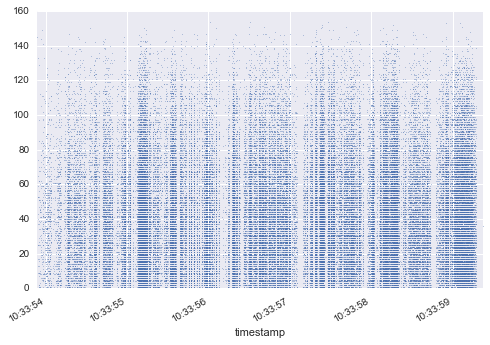

In [18]:
zi_data.spread.plot(linestyle='none', marker='o', markersize=1, alpha=0.5)
plt.show()

<h2> Compute raw returns </h2>

$$ r_{t+k} = \frac{p_{t+k} - p_{t}}{p_{t}} = \frac{\Delta p_{t+k}}{p_{t}}$$ 

Note that raw returns are bounded below! Bounds on price (at least in these simulations!) are $1 \le p_t \le 200$. Therefore lower bound on raw returns is...

$$ \underline{r} = \frac{1 - 200}{200} \approx -1. $$

Similarly, then upper bound on raw returns is...

$$ \underline{r} = \frac{200 - 1}{1} = 199. $$


In [19]:
zi_data['raw_returns'] = zi_data.price.pct_change(periods=1)

In [20]:
zi_data.raw_returns.describe()

count    99744.000000
mean         0.107589
std          0.528648
min         -0.770992
25%         -0.238462
50%          0.000000
75%          0.309340
max          8.250000
Name: raw_returns, dtype: float64

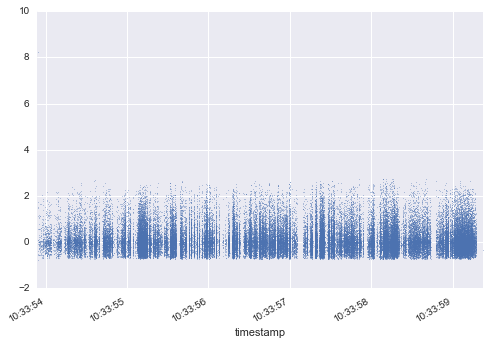

In [21]:
zi_data.raw_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.5)
plt.show()

## Compute logarithmic returns

Starting from raw returns, $r_{t+k}$ we see that...

$$ 1 + r_{t+k} = 1 + \frac{p_{t+k} - p_t}{p_t} = \frac{p_{t+k}}{p_t} $$

...taking logs yields...

$$ \ln \big(1 + r_{t+k}\big) = \ln p_{t+k} - \ln p_t = \Delta \ln p_{t+k} $$

...since $\ln \big(1 + r_{t+k}\big) \approx r_{t+k}$ for $r << 1$ we should expect that raw and logarithmic return formulas should yields similar results for "small" returns.


In [22]:
zi_data['log_returns'] = np.log(1 + zi_data.raw_returns)

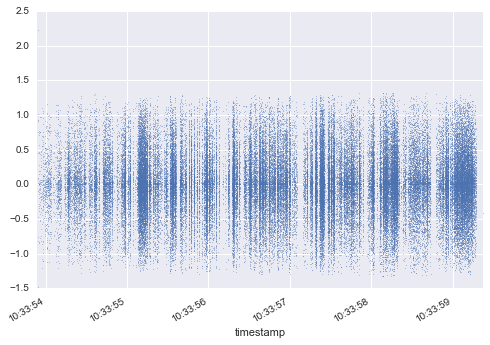

In [23]:
zi_data.log_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.5)
plt.show()

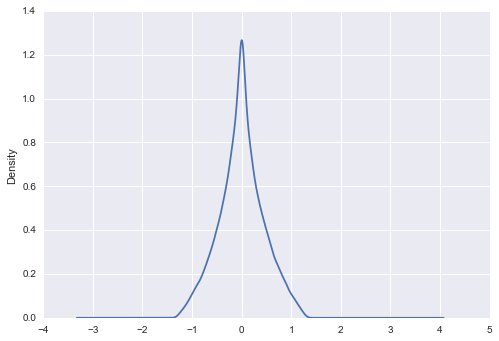

In [24]:
zi_data.log_returns.dropna().plot(kind='kde')
plt.show()

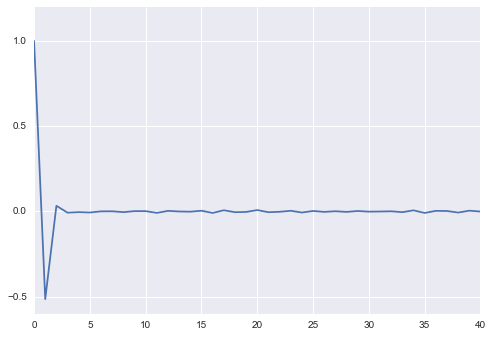

In [25]:
plt.plot(sm.tsa.acf(zi_data.log_returns.dropna(), fft=True))
plt.show()

<h3> Price impact </h3>

In [26]:
zi_data['mid_price'] = 0.5 * (zi_data.askPrice + zi_data.bidPrice)

How to best measure effective size? Particularly of ask orders!

In [27]:
zi_data['effective_size'] = zi_data.quantity

incoming_ask_orders = zi_data.bidPrice == zi_data.price
zi_data.loc[incoming_ask_orders, 'effective_size'] *= -zi_data.loc[incoming_ask_orders, 'askPrice']

incoming_bid_orders = zi_data.askPrice == zi_data.price
zi_data.loc[incoming_bid_orders, 'effective_size'] *= zi_data.loc[incoming_bid_orders, 'bidPrice']

Compute the measure of price impact: $\Delta \ln$ `mid_price`...

In [28]:
zi_data['price_impact'] = np.log(zi_data.mid_price).diff()

In [29]:
zi_data[incoming_ask_orders].head()

,askPrice,bidPrice,class,price,quantity,tradable,spread,raw_returns,log_returns,mid_price,effective_size,price_impact
timestamp,,,,,,,,,,,,
2016-03-24 10:33:53.910,86,145,markets.Fill,145,1,Gpi2,59,0.576087,0.454945,115.5,-86,-0.025642
2016-03-24 10:33:53.910,91,131,markets.Fill,131,1,Gpi2,40,-0.096552,-0.101536,111.0,-91,-0.039740
2016-03-24 10:33:53.910,21,30,markets.Fill,30,1,Gpi2,9,-0.531250,-0.757686,25.5,-21,-1.376442
2016-03-24 10:33:53.911,63,76,markets.Fill,76,1,Gpi2,13,1.533333,0.929536,69.5,-63,1.002648
2016-03-24 10:33:53.911,12,77,markets.Fill,77,1,Gpi2,65,0.013158,0.013072,44.5,-12,-0.445838


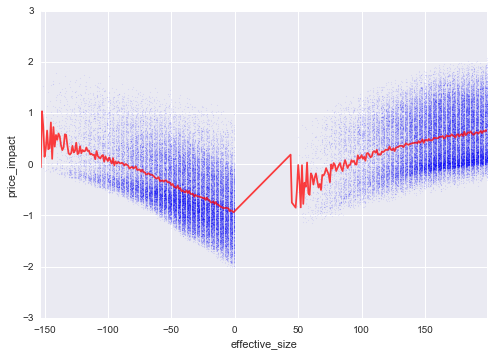

In [30]:
# incoming bid orders
fig, ax = plt.subplots(1, 1)
grouped_data = zi_data.groupby("effective_size")
grouped_data.price_impact.mean().plot(color='r', alpha=0.75, ax=ax)
ax.scatter(zi_data.effective_size, zi_data.price_impact, edgecolor='b', s=1, alpha=0.05)
ax.set_ylabel("price_impact")
plt.show()

## Cumulative distributions

In [31]:
ecdfs = {} 
for column_name in ['raw_returns', 'log_returns']:
    ecdfs[column_name] = sm.distributions.ECDF(zi_data[column_name].abs())

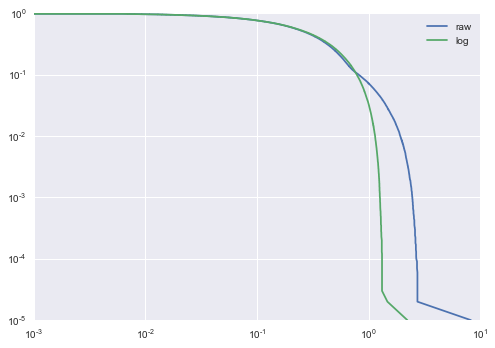

In [32]:
plt.plot(ecdfs['raw_returns'].x, 1 - ecdfs['raw_returns'].y, label='raw')
plt.plot(ecdfs['log_returns'].x, 1 - ecdfs['log_returns'].y, label='log')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

<h3> Zero Intelligence Constrained </h3>

In [33]:
!sbt "run-main ZeroIntelligenceConstrainedApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Running ZeroIntelligenceConstrainedApp 
[info] -XX:InitialHeapSize=268435456 -XX:MaxHeapSize=4294967296 -XX:+PrintCommandLineFlags -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseParallelGC 
[success] Total time: 7 s, completed Mar 24, 2016 10:52:58 AM


In [34]:
# this is a bit of a hack as current log files are not valid JSON!
with open('./data/fills.log') as data_file:    
    zic_data = pd.read_json('[%s]' % ','.join(data_file.read().splitlines()))
    zic_data.set_index('timestamp', inplace=True)

In [35]:
zic_data.describe()

,askPrice,bidPrice,price,quantity
count,32290.000000,32290.000000,32290.000000,32290
mean,83.093434,114.080365,97.800557,1
std,29.120990,29.954772,14.986855,0
min,0.000000,55.000000,55.000000,1
25%,63.000000,89.000000,85.000000,1
50%,88.000000,109.000000,98.000000,1
75%,107.000000,135.000000,110.000000,1
max,129.000000,198.000000,129.000000,1


In [36]:
zic_data['spread'] = zic_data.bidPrice - zic_data.askPrice
zic_data['raw_returns'] = zic_data.price.pct_change(periods=1)
zic_data['log_returns'] = np.log(1 + zic_data.raw_returns)

<h2> Imposing budget constraints on traders reduces spreads...</h2>

In [37]:
zi_data.spread.describe()

count    99745.000000
mean        43.835430
std         29.916339
min          1.000000
25%         20.000000
50%         39.000000
75%         62.000000
max        154.000000
Name: spread, dtype: float64

In [38]:
zic_data.spread.describe()

count    32290.000000
mean        30.986931
std         22.500573
min          1.000000
25%         12.000000
50%         26.000000
75%         46.000000
max        120.000000
Name: spread, dtype: float64

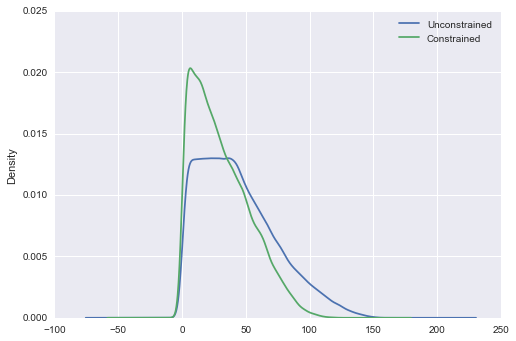

In [40]:
zi_data.spread.dropna().plot(kind='kde', label='Unconstrained')
zic_data.spread.dropna().plot(kind='kde', label='Constrained')
plt.legend()

plt.show()

<h2> Imposing budget constraints on traders reduces variance in returns...</h2>

In [43]:
zi_data.log_returns.describe()

count    99744.000000
mean         0.000027
std          0.451085
min         -1.474000
25%         -0.272415
50%          0.000000
75%          0.269523
max          2.224624
Name: log_returns, dtype: float64

In [44]:
zic_data.log_returns.describe()

count    32289.000000
mean        -0.000007
std          0.182676
min         -0.746257
25%         -0.106295
50%          0.000000
75%          0.105361
max          0.571786
Name: log_returns, dtype: float64

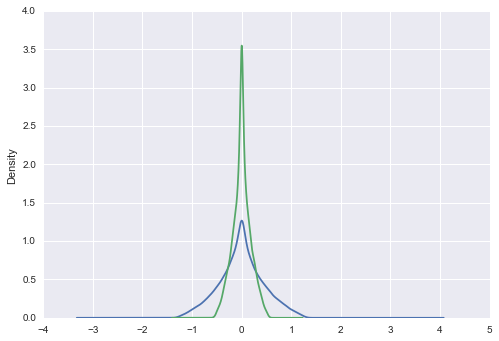

In [42]:
zi_data.log_returns.dropna().plot(kind='kde', label='Unconstrained')
zic_data.log_returns.dropna().plot(kind='kde', label='Constrained')
plt.show()